In [1125]:
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import numpy as np

from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
from sklearn.model_selection import GridSearchCV, cross_val_score

from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

# --- Step 1: Load both datasets ---
dfMarket = pd.read_csv("market_pipe_thickness_loss_dataset.csv")   # Market dataset

# Basic info
print("Dataset 1 info:")
dfMarket.info()

# Summary statistics
print("\nDataset 1 describe:")
print(dfMarket.describe())

print("Dataset shape: ", dfMarket.shape)

Dataset 1 info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 11 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pipe_Size_mm              1000 non-null   int64  
 1   Thickness_mm              1000 non-null   float64
 2   Material                  1000 non-null   object 
 3   Grade                     1000 non-null   object 
 4   Max_Pressure_psi          1000 non-null   int64  
 5   Temperature_C             1000 non-null   float64
 6   Corrosion_Impact_Percent  1000 non-null   float64
 7   Thickness_Loss_mm         1000 non-null   float64
 8   Material_Loss_Percent     1000 non-null   float64
 9   Time_Years                1000 non-null   int64  
 10  Condition                 1000 non-null   object 
dtypes: float64(5), int64(3), object(3)
memory usage: 86.1+ KB

Dataset 1 describe:
       Pipe_Size_mm  Thickness_mm  Max_Pressure_psi  Temperature_C  \
count   1


Missing values count:
Pipe_Size_mm                0
Thickness_mm                0
Material                    0
Grade                       0
Max_Pressure_psi            0
Temperature_C               0
Corrosion_Impact_Percent    0
Thickness_Loss_mm           0
Material_Loss_Percent       0
Time_Years                  0
Condition                   0
dtype: int64

Duplicate rows count:
0

Market dataset's number rows and columns:  (1000, 11)


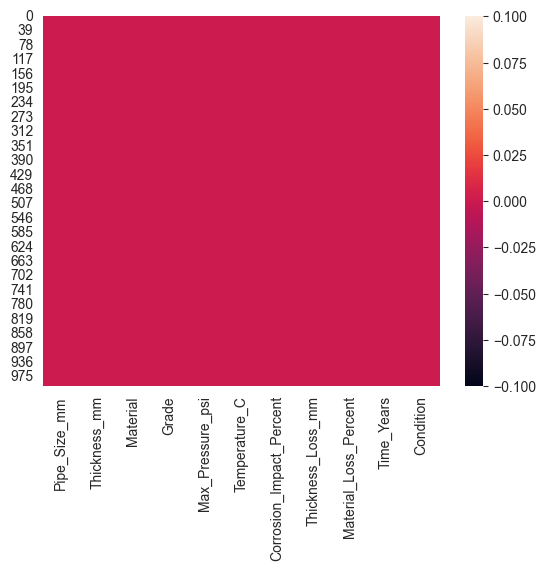

In [1126]:
#BASIC CLEANING
 #(handle missing values & duplicates,
 #rename column name into small letters,
 #check unique values,
 # handle outliers)

#Removing duplicates & missing values

print("\nMissing values count:")
print(dfMarket.isnull().sum())  # Check for null values
print("\nDuplicate rows count:")
print(dfMarket.duplicated().sum())  # Identify duplicate records
print("\nMarket dataset's number rows and columns: ", dfMarket.shape)

sns.heatmap(dfMarket.isnull())
plt.show()

In [1127]:
 #rename column name into small letters,
dfMarket.columns = dfMarket.columns.str.strip().str.lower()
print(dfMarket.columns)


 #check unique values,

dfMarket['material'] = dfMarket['material'].str.lower().str.replace('-', ' ').str.strip()
dfMarket['grade'] = dfMarket['grade'].str.lower().str.replace('-', ' ').str.strip()
dfMarket['condition'] = dfMarket['condition'].str.lower().str.replace('-', ' ').str.strip()

print("Unique values for material column: ",dfMarket['material'].unique())
print("Unique values for condition column: ",dfMarket['condition'].unique())
print("Unique values for grade column: ",dfMarket['grade'].unique())


Index(['pipe_size_mm', 'thickness_mm', 'material', 'grade', 'max_pressure_psi',
       'temperature_c', 'corrosion_impact_percent', 'thickness_loss_mm',
       'material_loss_percent', 'time_years', 'condition'],
      dtype='object')
Unique values for material column:  ['pvc' 'fiberglass' 'hdpe' 'carbon steel' 'stainless steel']
Unique values for condition column:  ['critical' 'moderate' 'normal']
Unique values for grade column:  ['astm a333 grade 6' 'api 5l x65' 'api 5l x42' 'astm a106 grade b'
 'api 5l x52']


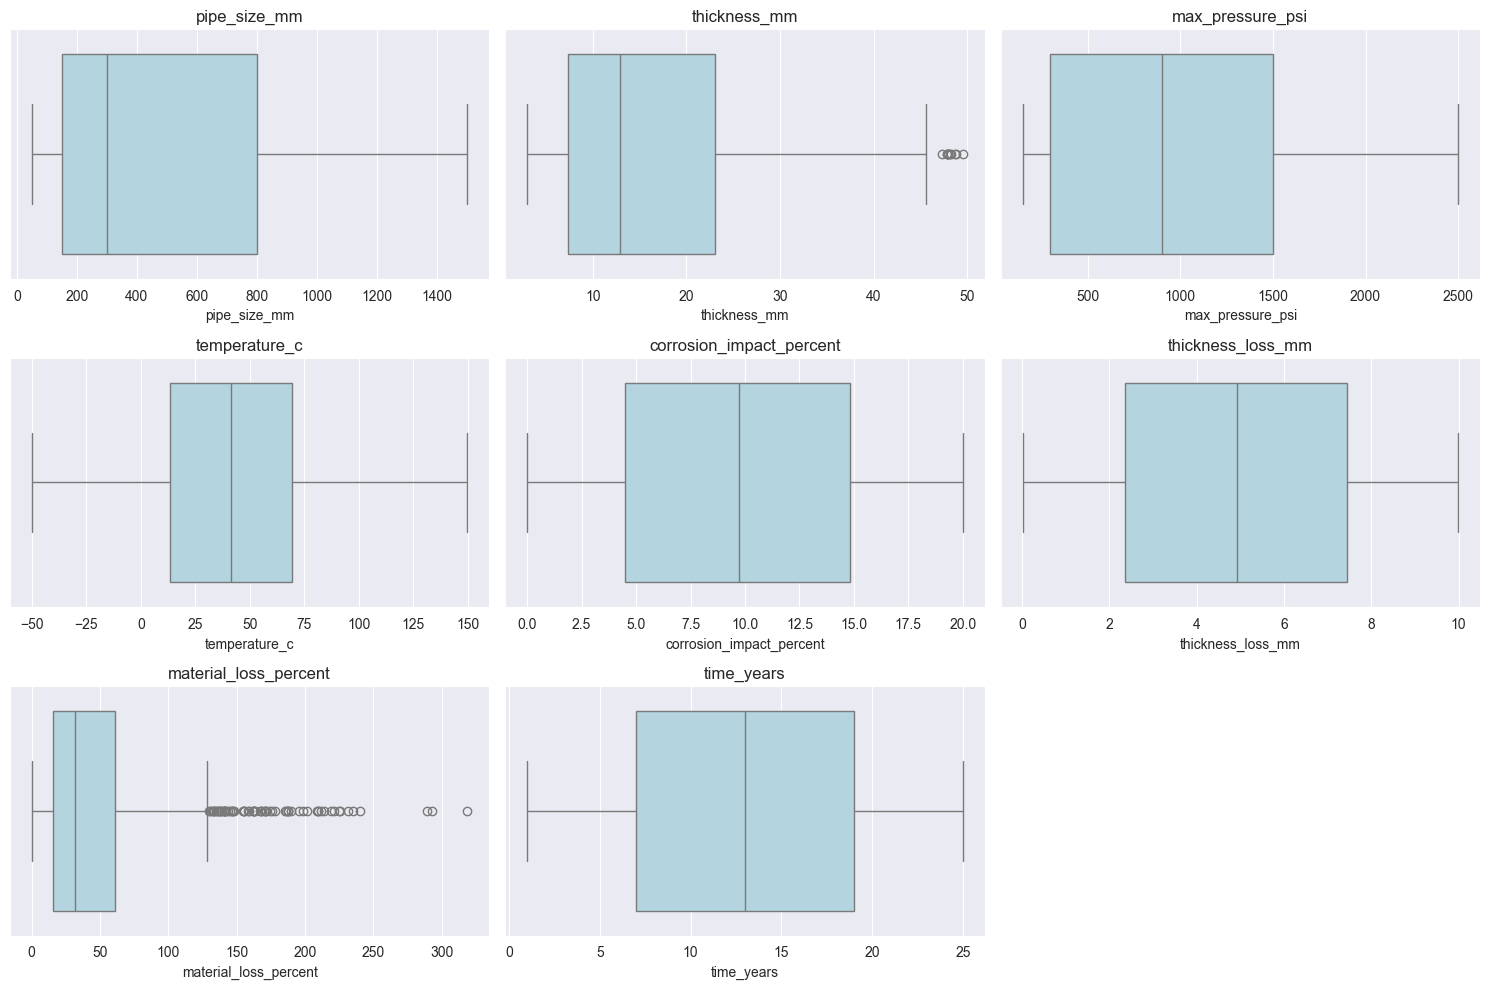

In [1128]:
 # checking and handle outliers for dataset Market)

# Market dataset
numeric_cols_market = ['pipe_size_mm', 'thickness_mm', 'max_pressure_psi',
                       'temperature_c', 'corrosion_impact_percent',
                       'thickness_loss_mm', 'material_loss_percent', 'time_years']

plt.figure(figsize=(15, 10))
for i, col in enumerate(numeric_cols_market, 1):
    plt.subplot(3, 3, i)
    sns.boxplot(x=dfMarket[col], color='lightblue')
    plt.title(col)
plt.tight_layout()
plt.show()



Insight:
only material_loss_percent needs to be fixed

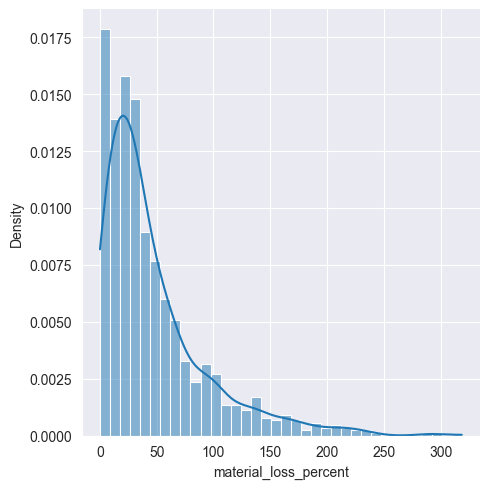

In [1129]:
#distribution plot of Material Loss Percent before capping outliers
displotMaterialLossBfr = sns.displot(dfMarket['material_loss_percent'], kde=True, stat='density')
plt.show()

thickness_mm bounds: -16.15 to 46.53
material_loss_percent bounds: -52.39 to 129.09

---Details of outliers in material_loss_percent---
Outliers below lower bound: 0
Outliers above upper bound: 70


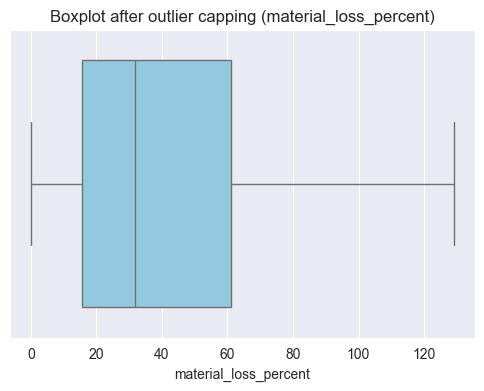

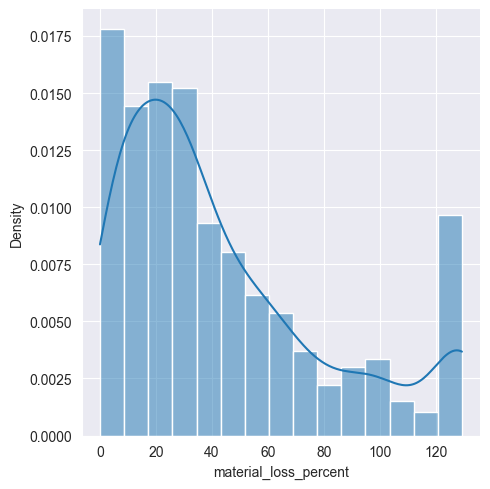

In [1130]:
#BASIC DATA CLEANING
#fixing outliers

# Define a function to detect outlier bounds using IQR
def find_outlier_bounds(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return lower_bound, upper_bound

# Find lower and upper bounds for the two columns (tells what is considered normal, other than that is an outlier)
lb_thick, ub_thick = find_outlier_bounds(dfMarket, 'thickness_mm')
lb_loss, ub_loss = find_outlier_bounds(dfMarket, 'material_loss_percent')

print(f"thickness_mm bounds: {lb_thick:.2f} to {ub_thick:.2f}")
print(f"material_loss_percent bounds: {lb_loss:.2f} to {ub_loss:.2f}")
  #CONC: will be only handling outliers in material_loss_percent since it can be possible/logic for thickness_mm (heavy duty pipe)

#check how many rows have values below the lower bound and above the upper bound
outliers_below = (dfMarket['material_loss_percent'] < lb_loss).sum()
outliers_above = (dfMarket['material_loss_percent'] > ub_loss).sum()
print("\n---Details of outliers in material_loss_percent---")
print(f"Outliers below lower bound: {outliers_below}")
print(f"Outliers above upper bound: {outliers_above}")

#Capping/Winsorizing = fix the outliers to nearest valid boundary
dfMarket['material_loss_percent'] = dfMarket['material_loss_percent'].clip(lb_loss, ub_loss)

#visualizing
plt.figure(figsize=(6,4))
sns.boxplot(x=dfMarket['material_loss_percent'], color='skyblue')
plt.title("Boxplot after outlier capping (material_loss_percent)")
plt.show()

#distribution plot of Material Loss Percent after capping outliers
displotMaterialLossAf = sns.displot(dfMarket['material_loss_percent'], kde=True, stat='density')
plt.show()



In [1131]:

#dropping grade column for both dataset since it has no context
dfMarket = dfMarket.drop(columns=['grade'])

print("Current columns in dataset: ", dfMarket.columns)


Current columns in dataset:  Index(['pipe_size_mm', 'thickness_mm', 'material', 'max_pressure_psi',
       'temperature_c', 'corrosion_impact_percent', 'thickness_loss_mm',
       'material_loss_percent', 'time_years', 'condition'],
      dtype='object')


Data Visualization of Dataset


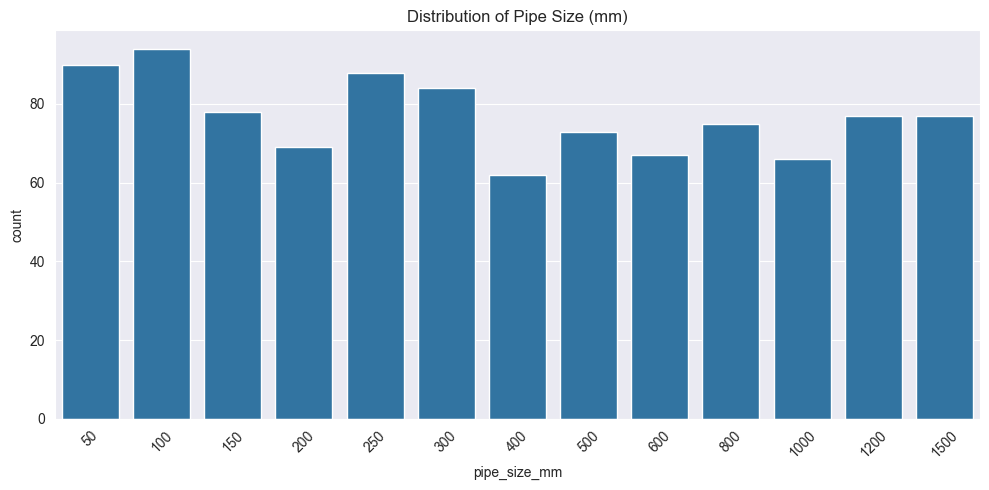

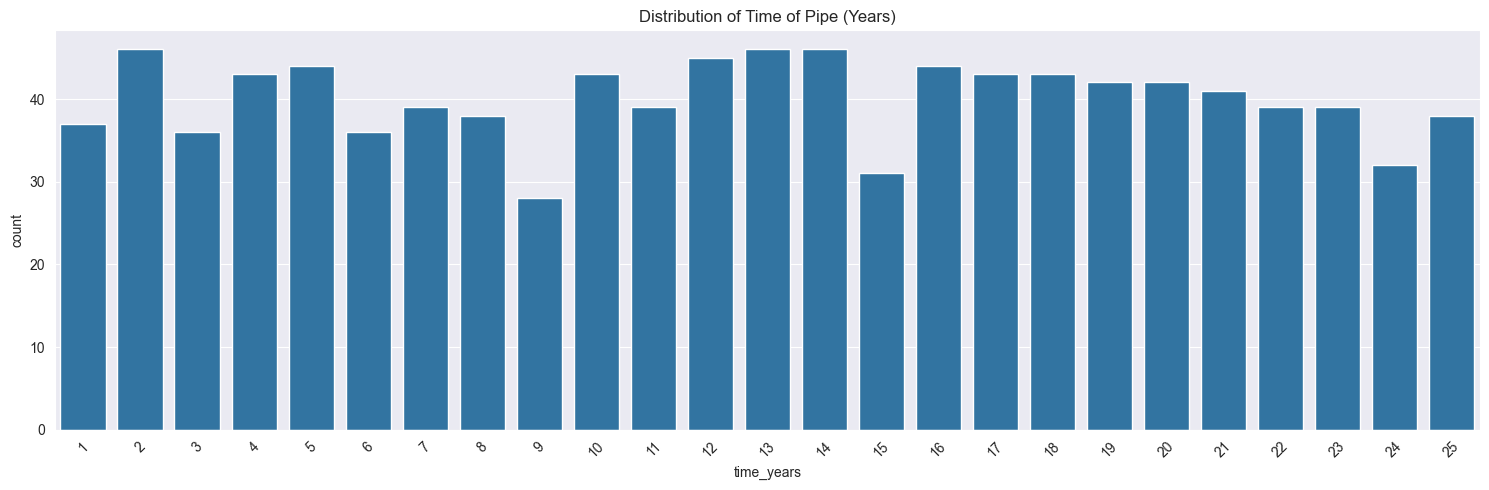

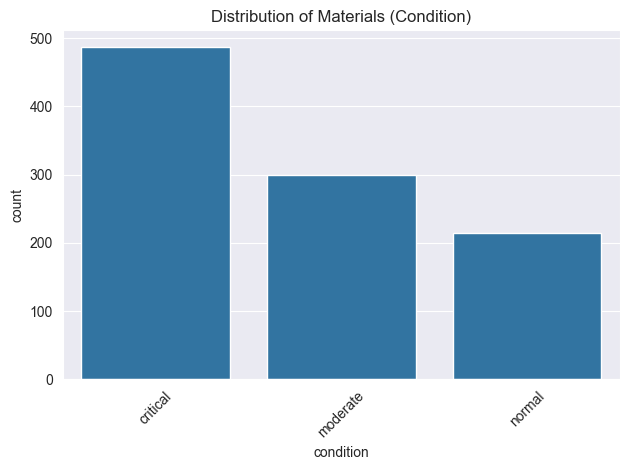

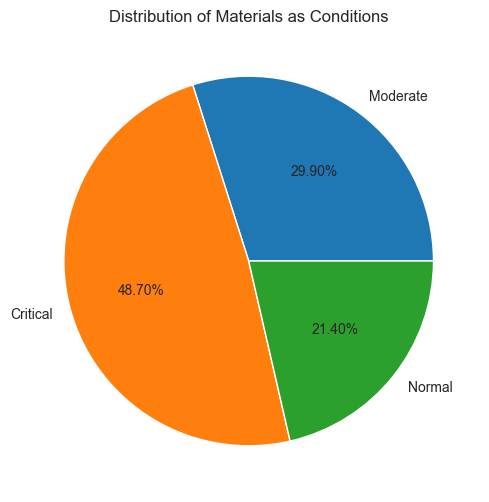

In [1132]:
# DATA VISUALIZATION
import plotly.express as px

# Graph 1: Material grade distribution (Plotly - Already Good)
fig = px.bar(dfMarket, x='material', title="Different Types of Materials")
fig.show()

# Graph 2: Pipe size distribution (Seaborn)
plt.figure(figsize=(10,5))
sns.countplot(data=dfMarket, x='pipe_size_mm')
plt.title("Distribution of Pipe Size (mm)")  # <-- Title must be separate
plt.xticks(rotation=45)  # Optional: Rotate labels if too many
plt.tight_layout()
plt.show()

# Graph 3: Time of Pipe Distribution (Seaborn)
plt.figure(figsize=(15,5))
sns.countplot(data=dfMarket, x='time_years')
plt.title("Distribution of Time of Pipe (Years)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#graph 4: material condiiton distribution
sns.countplot(data = dfMarket, x = 'condition')
plt.title("Distribution of Materials (Condition)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


plt.figure(figsize = (6,6))
Moderate_B = dfMarket.loc[(dfMarket['condition'] == 'moderate')].count()
Critical_C = dfMarket.loc[(dfMarket['condition'] == 'critical')].count()
Normal_A = dfMarket.loc[(dfMarket['condition'] == 'normal')].count()


#print(groupA['EthnicGroup'])

mlist = [Moderate_B['condition'], Critical_C['condition'], Normal_A['condition']]

l = ['Moderate', 'Critical', 'Normal']

plt.pie(mlist, labels = l, autopct = '%1.2f%%')
#print(mlist)
plt.title('Distribution of Materials as Conditions')

plt.show()

Encoding categorical data

material = nominal data (no order) = one hot encoding


condition = ordinal data (got order) = label encoding

In [1133]:
#feature engineering on categorical data on 4 cat columns : material, condition

for col in ['material', 'condition']:
    print(f"{col} unique values:\n{dfMarket[col].unique()}\n")

material unique values:
['pvc' 'fiberglass' 'hdpe' 'carbon steel' 'stainless steel']

condition unique values:
['critical' 'moderate' 'normal']



In [1134]:
# --- ONE-HOT ENCODING FOR 'material' COLUMN ---

from sklearn.preprocessing import OneHotEncoder
import pandas as pd

# Select the categorical column
catData = dfMarket[['material']]

# Initialize OneHotEncoder
ohe = OneHotEncoder(sparse_output=False)

# Fit and transform the data
encoded_array = ohe.fit_transform(catData)

# Convert the encoded array back into a DataFrame with proper column names
encoded_df = pd.DataFrame(encoded_array, columns=ohe.get_feature_names_out(['material']))

# Combine encoded columns with original dataframe (optional)
df_encoded = pd.concat([dfMarket.reset_index(drop=True), encoded_df], axis=1)

# Display final encoded dataframe
print(df_encoded.head())


   pipe_size_mm  thickness_mm    material  max_pressure_psi  temperature_c  \
0            50          4.55         pvc               600           51.7   
1            50          4.05         pvc               150           63.0   
2            50          4.11  fiberglass               150           44.5   
3            50          3.60  fiberglass              2500           20.2   
4            50          5.73        hdpe              1500          136.8   

   corrosion_impact_percent  thickness_loss_mm  material_loss_percent  \
0                     14.89               8.91                 129.09   
1                     16.94               9.53                 129.09   
2                      7.24               3.39                  82.48   
3                     15.29               7.69                 129.09   
4                     16.74               3.89                  67.89   

   time_years condition  material_carbon steel  material_fiberglass  \
0           1  critic

In [1135]:
# --- LABEL ENCODING FOR 'condition' COLUMN ---

# Define the order of severity
condition_mapping = {
    'normal': 0,
    'moderate': 1,
    'critical': 2
}

# Apply the mapping to the original dataframe - use map and not Labelencoder/OrdinalEncoder coz have full control over order
dfMarket['condition_encoded'] = dfMarket['condition'].map(condition_mapping)

# Display the first few rows
print(dfMarket[['condition', 'condition_encoded']].head())


  condition  condition_encoded
0  critical                  2
1  critical                  2
2  moderate                  1
3  critical                  2
4  moderate                  1


In [1136]:
# Combine the encoded material columns with the condition-encoded column
dfMarket = pd.concat([df_encoded.reset_index(drop=True),
                      dfMarket[['condition_encoded']].reset_index(drop=True)], axis=1)

# Optional: drop original categorical columns if not needed
# df_final = df_final.drop(columns=['material', 'condition'])

print(dfMarket.head())

   pipe_size_mm  thickness_mm    material  max_pressure_psi  temperature_c  \
0            50          4.55         pvc               600           51.7   
1            50          4.05         pvc               150           63.0   
2            50          4.11  fiberglass               150           44.5   
3            50          3.60  fiberglass              2500           20.2   
4            50          5.73        hdpe              1500          136.8   

   corrosion_impact_percent  thickness_loss_mm  material_loss_percent  \
0                     14.89               8.91                 129.09   
1                     16.94               9.53                 129.09   
2                      7.24               3.39                  82.48   
3                     15.29               7.69                 129.09   
4                     16.74               3.89                  67.89   

   time_years condition  material_carbon steel  material_fiberglass  \
0           1  critic

Feature Scaling using Standard Scaler

In [1175]:
#using Standard Scaler for material loss percent column only
from sklearn.preprocessing import StandardScaler
import joblib
ss = StandardScaler()
ss.fit(dfMarket[["material_loss_percent"]])
material_loss_percent_ss = ss.transform(dfMarket[["material_loss_percent"]])
dfMarket["material_loss_percent_ss"] = material_loss_percent_ss

joblib.dump(ss, "material_loss_scaler.pkl")
print("✅ StandardScaler saved as 'material_loss_scaler.pkl'")

✅ StandardScaler saved as 'material_loss_scaler.pkl'


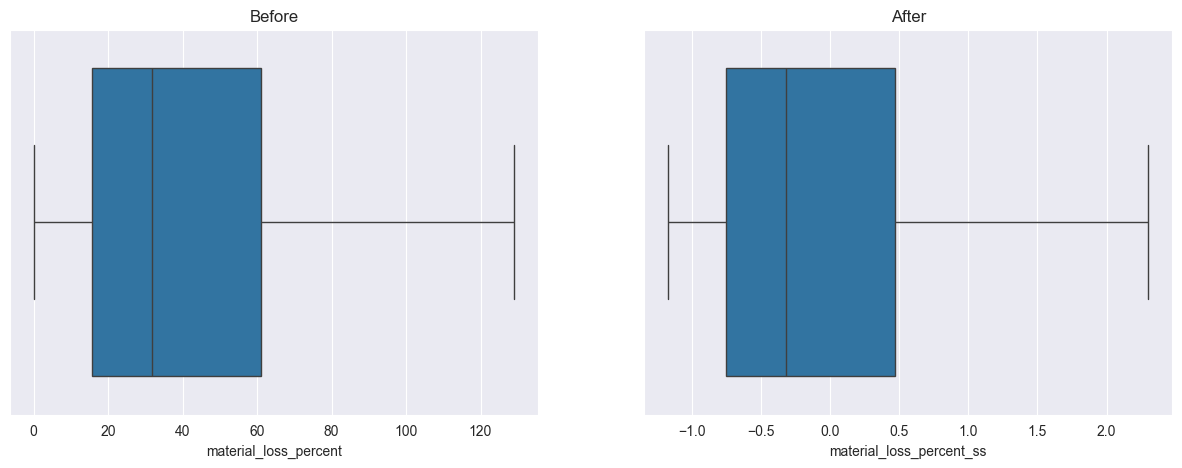

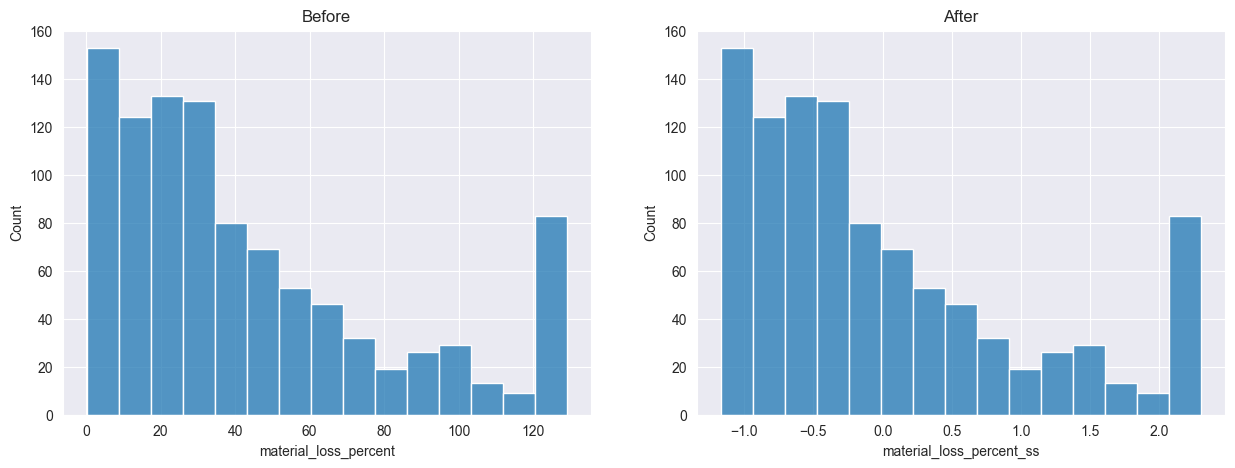

In [1138]:
# 1 mean row, 2 mean column, 1 show position 1

plt.figure(figsize = (15,5))

plt.subplot(1,2,1)
plt.title("Before")
sns.boxplot(data = dfMarket, x = "material_loss_percent")


plt.subplot(1,2,2)
plt.title("After")
sns.boxplot(data = dfMarket, x = "material_loss_percent_ss")

plt.show()

# 1 mean row, 2 mean column, 1 show position 1

plt.figure(figsize = (15,5))

plt.subplot(1,2,1)
plt.title("Before")
sns.histplot(data = dfMarket, x = "material_loss_percent")


plt.subplot(1,2,2)
plt.title("After")
sns.histplot(data = dfMarket, x = "material_loss_percent_ss")


plt.show()

Function Transformer

In [1174]:
from sklearn.preprocessing import FunctionTransformer
import joblib
ft = FunctionTransformer(func = np.log1p)

ft.fit(dfMarket[["pipe_size_mm"]])
ft.transform(dfMarket[["pipe_size_mm"]])

dfMarket["pipe_size_mm_tf"] = ft.transform(dfMarket[["pipe_size_mm"]])

joblib.dump(ft, "size_transformer.pkl")
print("✅ Model and transformers saved successfully!")

✅ Model and transformers saved successfully!


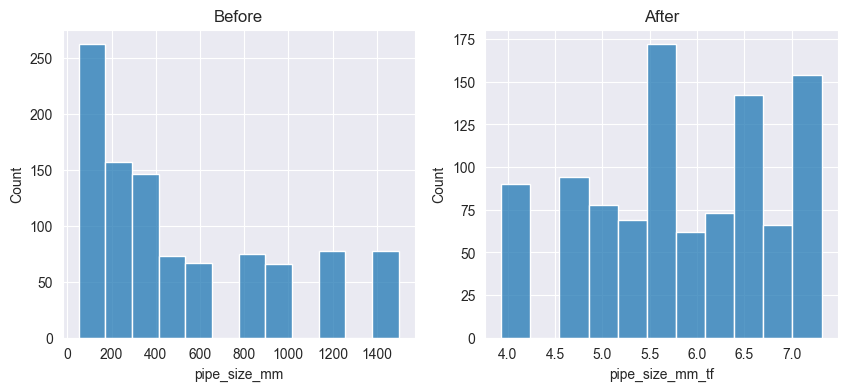

In [1140]:
plt.figure(figsize = (10,4))
plt.subplot(1,2,1)
plt.title("Before")
sns.histplot(dfMarket["pipe_size_mm"])

plt.subplot(1,2,2)
plt.title("After")
sns.histplot(dfMarket["pipe_size_mm_tf"])
plt.show()

Feature Engineering

In [1141]:
#FE on numerical data
#feature 1: Corrosion Rate (mm per year)
#Measures how fast the pipe loses thickness each year.
dfMarket['corrosion_rate_mm_per_year'] = dfMarket['thickness_loss_mm'] / dfMarket['time_years']

#feature 2: Pressure to Thickness Ratio
#Higher ratio → higher stress on the pipe wall → faster corrosion risk.
dfMarket['pressure_to_thickness'] = dfMarket['max_pressure_psi'] / dfMarket['thickness_mm']

#feature 3: material loss ratio
#shows percentage of material loss compared to total corrosion impact
dfMarket['loss_ratio'] = dfMarket['material_loss_percent'] / (dfMarket['corrosion_impact_percent'] + 1e-6)

#how much heat the pipeline has experienced over time.“if temperature and exposure time are both high, corrosion risk rises.”
dfMarket['temp_time_interaction'] = dfMarket['temperature_c'] * dfMarket['time_years']
dfMarket['size_pressure_index'] = dfMarket['pipe_size_mm_tf'] * dfMarket['max_pressure_psi']

dfMarket['pressure_temp_interaction'] = dfMarket['max_pressure_psi'] * dfMarket['temperature_c']




In [1142]:
#feature engineering on categorical data
# --- Material Risk Index based on corrosion susceptibility ---
risk_map = {
    'material_carbon steel': 3,       # High risk
    'material_fiberglass': 0,         # Very low risk
    'material_hdpe': 0,               # Very low risk
    'material_pvc': 0,                # Very low risk
    'material_stainless steel': 1     # Low risk
}

# --- Compute Material_Risk_Index ---
# Multiply each one-hot column by its risk value, then sum across rows
dfMarket['material_risk_index'] = sum(
    dfMarket[col] * risk for col, risk in risk_map.items()
)


# feature 6:. Stress Index
dfMarket['Stress_Index'] = dfMarket['max_pressure_psi'] / (dfMarket['thickness_mm'] / dfMarket['pipe_size_mm'])

# feature 7. Temp Factor
dfMarket['Temp_Factor'] = np.exp(dfMarket['temperature_c'] / 100)

# feature 9: Operational Stress Age
dfMarket['Operational_Stress_Age'] = dfMarket['max_pressure_psi'] * dfMarket['time_years']



In [1143]:
#Reflects stress level distribution
dfMarket['pressure_to_size'] = dfMarket['max_pressure_psi'] / dfMarket['pipe_size_mm_tf']

#Captures heat-related degradation
dfMarket['temp_age_interaction'] = dfMarket['temperature_c'] * dfMarket['time_years']

#High stress + high pressure = risk
dfMarket['pressure_stress_interaction'] = dfMarket['max_pressure_psi'] * dfMarket['Stress_Index']

#Represents wall proportion
dfMarket['normalized_thickness'] = dfMarket['thickness_mm'] / dfMarket['pipe_size_mm_tf']

dfMarket["thickness_decay_ratio"] = dfMarket['thickness_mm'] / dfMarket['time_years']


In [1144]:
#one hot encoding for time years
# Define bins and labels
bins = [0, 5, 10, 15, 20, 25, float('inf')]
labels = ['1–5 years', '6–10 years', '11–15 years', '16–20 years', '21–25 years', '25+ years']

# Create Age_Group column
dfMarket['age_group'] = pd.cut(dfMarket['time_years'], bins=bins, labels=labels, right=True)

# One-hot encode Age_Group and convert to int
age_group_encoded = pd.get_dummies(dfMarket['age_group'], prefix='age_group').astype(int)

# Concatenate back to main dataframe
dfMarket = pd.concat([dfMarket, age_group_encoded], axis=1)

# (Optional) Drop Age_Group if you don’t want to keep it
# dfMarket.drop(columns=['Age_Group'], inplace=True)

# Preview result
print(dfMarket[['time_years', 'age_group'] + list(age_group_encoded.columns)].head())


   time_years    age_group  age_group_1–5 years  age_group_6–10 years  \
0           1    1–5 years                    1                     0   
1           1    1–5 years                    1                     0   
2          15  11–15 years                    0                     0   
3           2    1–5 years                    1                     0   
4           4    1–5 years                    1                     0   

   age_group_11–15 years  age_group_16–20 years  age_group_21–25 years  \
0                      0                      0                      0   
1                      0                      0                      0   
2                      1                      0                      0   
3                      0                      0                      0   
4                      0                      0                      0   

   age_group_25+ years  
0                    0  
1                    0  
2                    0  
3               

In [1145]:
print(dfMarket.columns)
print(dfMarket.shape)



Index(['pipe_size_mm', 'thickness_mm', 'material', 'max_pressure_psi',
       'temperature_c', 'corrosion_impact_percent', 'thickness_loss_mm',
       'material_loss_percent', 'time_years', 'condition',
       'material_carbon steel', 'material_fiberglass', 'material_hdpe',
       'material_pvc', 'material_stainless steel', 'condition_encoded',
       'material_loss_percent_ss', 'pipe_size_mm_tf',
       'corrosion_rate_mm_per_year', 'pressure_to_thickness', 'loss_ratio',
       'temp_time_interaction', 'size_pressure_index',
       'pressure_temp_interaction', 'material_risk_index', 'Stress_Index',
       'Temp_Factor', 'Operational_Stress_Age', 'pressure_to_size',
       'temp_age_interaction', 'pressure_stress_interaction',
       'normalized_thickness', 'thickness_decay_ratio', 'age_group',
       'age_group_1–5 years', 'age_group_6–10 years', 'age_group_11–15 years',
       'age_group_16–20 years', 'age_group_21–25 years',
       'age_group_25+ years'],
      dtype='object')
(1000

Train and test

In [1146]:
from sklearn.model_selection import GridSearchCV
original_cols = [
    'pipe_size_mm_tf', 'thickness_mm', 'material_carbon steel', 'material_fiberglass', 'material_hdpe',
    'material_pvc', 'material_stainless steel','max_pressure_psi', 'temperature_c', 'corrosion_impact_percent','time_years',
    'age_group_1–5 years','age_group_6–10 years', 'age_group_11–15 years','age_group_16–20 years', 'age_group_21–25 years','age_group_25+ years'
]

input_cols = [
    'thickness_mm', 'max_pressure_psi', 'temperature_c',
    'corrosion_impact_percent', 'thickness_loss_mm',
    'time_years',
    'material_carbon steel', 'material_fiberglass', 'material_hdpe',
    'material_pvc', 'material_stainless steel',
    'material_loss_percent_ss', 'pipe_size_mm_tf',
    'corrosion_rate_mm_per_year', 'pressure_to_thickness', 'loss_ratio',
    'material_risk_index'
]
safe_features = [
    'thickness_mm', 'max_pressure_psi', 'temperature_c',
    'time_years',
    'material_carbon steel', 'material_fiberglass', 'material_hdpe',
    'material_pvc', 'material_stainless steel',
    'pipe_size_mm_tf',
    'material_risk_index', 'pressure_to_thickness'
]

safe_featuresFE = [
    'thickness_mm', 'max_pressure_psi', 'temperature_c',
    'time_years', 'pipe_size_mm_tf',
    'material_carbon steel', 'material_fiberglass',
    'material_hdpe', 'material_pvc', 'material_stainless steel',
    'material_risk_index', 'pressure_to_thickness',
    'pressure_to_thickness_ratio', 'temp_time_interaction', 'size_pressure_index'
]

safe_featuresFE1 = [
    'thickness_mm', 'max_pressure_psi', 'temperature_c',
    'time_years', 'pipe_size_mm_tf',
    'material_carbon steel', 'material_fiberglass',
    'material_hdpe', 'material_pvc', 'material_stainless steel',
    'material_risk_index', 'pressure_to_thickness',
    'pressure_to_thickness_ratio', 'temp_time_interaction', 'size_pressure_index',

    'corrosion_impact_percent'
]

safe_featuresFE2 = [
    'thickness_mm', 'max_pressure_psi', 'temperature_c',
    'time_years', 'pipe_size_mm_tf',

    'material_carbon steel', 'material_fiberglass',
    'material_hdpe', 'material_pvc', 'material_stainless steel',

    'material_risk_index', 'pressure_to_thickness',
    'temp_time_interaction',
    'size_pressure_index', 'pressure_temp_interaction',

    'corrosion_impact_percent', 'thickness_decay_ratio'
]

#material_loss_percent_ss is a good predictor but causes multicollinearity/noise
#correlation = 0.585 between material_loss_percent_ss and condition_encoded
#result = 0.94
safe_featuresFE3 = [
    'thickness_mm', 'max_pressure_psi', 'temperature_c',
    'time_years', 'pipe_size_mm_tf',

    'material_carbon steel', 'material_fiberglass',
    'material_hdpe', 'material_pvc', 'material_stainless steel',

    'material_risk_index', 'pressure_to_thickness',
    'temp_time_interaction',
    'size_pressure_index', 'pressure_temp_interaction', 'material_loss_percent_ss'

    'corrosion_impact_percent', 'Stress_Index', 'Temp_Factor', 'Operational_Stress_Age'
]

#0.57
safe_featuresFE4 = [
    'thickness_mm', 'max_pressure_psi', 'temperature_c',
    'time_years', 'pipe_size_mm_tf',

    'material_carbon steel', 'material_fiberglass',
    'material_hdpe', 'material_pvc', 'material_stainless steel',

    'material_risk_index', 'pressure_to_thickness',
    'temp_time_interaction',
    'size_pressure_index', 'pressure_temp_interaction',

    'corrosion_impact_percent', 'Stress_Index', 'Temp_Factor', 'Operational_Stress_Age'
]

#result after feature seletion is 0.54, whiich is lower than safe_featuresFE4 whihc is at 0.58
safe_featuresFSelection = [
    'max_pressure_psi',
    'time_years', 'pipe_size_mm_tf',

    'material_carbon steel', 'material_fiberglass',
    'material_hdpe', 'material_pvc', 'material_stainless steel',

    'material_risk_index', 'pressure_to_thickness',
    'size_pressure_index', 'pressure_temp_interaction',

    'Stress_Index'
]
#0.85...hua terima kasih ya allah
safe_featuresFE5 = [
    'thickness_mm', 'max_pressure_psi', 'temperature_c',
    'time_years', 'pipe_size_mm_tf',

    'material_carbon steel', 'material_fiberglass',
    'material_hdpe', 'material_pvc', 'material_stainless steel',

    'material_risk_index', 'pressure_to_thickness',
    'temp_time_interaction',
    'size_pressure_index', 'pressure_temp_interaction',

    'loss_ratio',

    'corrosion_impact_percent', 'Stress_Index', 'Temp_Factor', 'Operational_Stress_Age', 'pressure_to_size',

    'temp_age_interaction', 'pressure_stress_interaction', 'normalized_thickness', 'thickness_decay_ratio',

    'age_group_1–5 years','age_group_6–10 years', 'age_group_11–15 years','age_group_16–20 years', 'age_group_21–25 years',

    'age_group_25+ years'

]
#feature importance (base acc = 0.85)
#0.93, overfit slightly
safe_featuresFS5 = ['loss_ratio',  'pipe_size_mm_tf','corrosion_impact_percent', 'thickness_mm','normalized_thickness']

#0.84
safe_featuresFS10 = ['loss_ratio',  'pipe_size_mm_tf','corrosion_impact_percent', 'thickness_mm','normalized_thickness',
                     'material_risk_index', 'material_fiberglass','age_group_1–5 years','pressure_stress_interaction','material_carbon steel']

#0.84
safe_featuresFS15 = ['loss_ratio',  'pipe_size_mm_tf','corrosion_impact_percent', 'thickness_mm','normalized_thickness',
                     'material_risk_index', 'material_fiberglass','age_group_1–5 years','pressure_stress_interaction','material_carbon steel',
                      'Stress_Index','size_pressure_index','pressure_to_thickness','pressure_to_size','thickness_decay_ratio']

#0.85, stable model, balanced generalization and accuracy
safe_featuresFS20 = ['loss_ratio',  'pipe_size_mm_tf','corrosion_impact_percent', 'thickness_mm','normalized_thickness',
                     'material_risk_index', 'material_fiberglass','age_group_1–5 years','pressure_stress_interaction','material_carbon steel',
                      'Stress_Index','size_pressure_index','pressure_to_thickness','pressure_to_size','thickness_decay_ratio',
                     'pressure_temp_interaction','material_pvc', 'Operational_Stress_Age','age_group_6–10 years','max_pressure_psi']

input_data = dfMarket[safe_featuresFS20]
output_data = dfMarket["condition_encoded"]

from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

smote = SMOTE(random_state=42)
x_resampled, y_resampled = smote.fit_resample(
    input_data,
    output_data)

x_train, x_test, y_train, y_test = train_test_split(
    x_resampled,
    y_resampled,
    test_size=0.25,
    stratify=y_resampled,
    random_state=42
)



In [1147]:
# Check new balance
print(y_resampled.value_counts())

condition_encoded
2    487
1    487
0    487
Name: count, dtype: int64


In [1148]:
x_train.shape, y_train.shape

((1095, 20), (1095,))

In [1149]:
x_test.shape, y_test.shape

((366, 20), (366,))

Baseline XGB


In [1150]:
# ===== BASIC XGBOOST MODEL (NO SMOTE, NO TUNING) =====

input_data_basic = dfMarket[original_cols]
output_data_basic = dfMarket["condition_encoded"]

# Step 2: Split into training and testing sets (no SMOTE)
x_trainbasic, x_testbasic, y_trainbasic, y_testbasic = train_test_split(
    input_data_basic,
    output_data_basic,
    test_size=0.25,
    stratify=output_data_basic,
    random_state=42
)

# Step 3: Train basic XGB model
xgb_basic = XGBClassifier(
    random_state=42,
    eval_metric='mlogloss'  # prevents warnings
)
xgb_basic.fit(x_trainbasic, y_trainbasic)

# Step 4: Predictions
y_pred_basic = xgb_basic.predict(x_testbasic)

# Step 5: Evaluation metrics
basic_acc = accuracy_score(y_testbasic, y_pred_basic)
basic_f1 = f1_score(y_testbasic, y_pred_basic, average='macro')

print("=== Basic XGBoost Model (No SMOTE, No Tuning) ===")
print(f"Accuracy: {basic_acc:.3f}")
print(f"Macro F1: {basic_f1:.3f}\n")

print("Classification Report:")
print(classification_report(y_testbasic, y_pred_basic))

print("Confusion Matrix:")
print(confusion_matrix(y_testbasic, y_pred_basic))

# Store results for comparison later
results_basic_xgb = {
    'Model': 'Basic XGBoost (No SMOTE)',
    'Accuracy': basic_acc,
    'F1-Macro': basic_f1
}


=== Basic XGBoost Model (No SMOTE, No Tuning) ===
Accuracy: 0.356
Macro F1: 0.278

Classification Report:
              precision    recall  f1-score   support

           0       0.08      0.06      0.07        53
           1       0.28      0.25      0.27        75
           2       0.46      0.55      0.50       122

    accuracy                           0.36       250
   macro avg       0.27      0.29      0.28       250
weighted avg       0.33      0.36      0.34       250

Confusion Matrix:
[[ 3 17 33]
 [10 19 46]
 [24 31 67]]


Tuned XGBoost (F.E + F.Selection + hyperparameter tuning + F.Importance + CV)

In [1151]:
# ===== TUNED XGBOOST MODEL =====

# Parameter grid
params_xgb = {
    'max_depth': [4, 6, 8],
    'learning_rate': [0.05, 0.1, 0.2],
    'n_estimators': [100, 200, 300],
    'subsample': [0.7, 0.8, 1.0],
    'colsample_bytree': [0.7, 0.8, 1.0],
    'gamma': [0, 0.1, 0.3]
}

# Base model
xgb_base = XGBClassifier(
    reg_alpha=0.1,
    reg_lambda=1.0,
    random_state=42,
    eval_metric='mlogloss'
)

# GridSearchCV
grid_xgb = GridSearchCV(
    xgb_base,
    params_xgb,
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)

# Fit model
grid_xgb.fit(x_train, y_train)
best_xgb_model = grid_xgb.best_estimator_

# Predictions
y_pred_xgb = best_xgb_model.predict(x_test)

# Store metrics
xgb_results = {
    "Best Params": grid_xgb.best_params_,
    "Accuracy": accuracy_score(y_test, y_pred_xgb),
    "F1 Macro": f1_score(y_test, y_pred_xgb, average='macro'),
    "Report": classification_report(y_test, y_pred_xgb, target_names=['Normal', 'Moderate', 'Critical']),
    "Confusion Matrix": confusion_matrix(y_test, y_pred_xgb)
}

# Display
print("=== XGBOOST RESULTS ===")
print("Best Parameters:", xgb_results["Best Params"])
print(f"Accuracy: {xgb_results['Accuracy']:.3f}")
print(f"F1 Macro: {xgb_results['F1 Macro']:.3f}")
print("\nClassification Report:\n", xgb_results["Report"])
print("Confusion Matrix:\n", xgb_results["Confusion Matrix"])

# Cross-validation
cv_acc_xgb = cross_val_score(best_xgb_model, input_data, output_data, cv=5, scoring='accuracy')
cv_f1_xgb = cross_val_score(best_xgb_model, input_data, output_data, cv=5, scoring='f1_macro')

print("\n=== Cross Validation (XGBoost) ===")
print("CV Accuracy:", cv_acc_xgb)
print("Mean CV Accuracy:", cv_acc_xgb.mean())
print("CV F1 Macro:", cv_f1_xgb)
print("Mean CV F1 Macro:", cv_f1_xgb.mean())


=== XGBOOST RESULTS ===
Best Parameters: {'colsample_bytree': 0.8, 'gamma': 0.3, 'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 300, 'subsample': 0.7}
Accuracy: 0.847
F1 Macro: 0.847

Classification Report:
               precision    recall  f1-score   support

      Normal       0.92      0.89      0.90       122
    Moderate       0.79      0.77      0.78       122
    Critical       0.83      0.89      0.86       122

    accuracy                           0.85       366
   macro avg       0.85      0.85      0.85       366
weighted avg       0.85      0.85      0.85       366

Confusion Matrix:
 [[108  11   3]
 [  9  94  19]
 [  0  14 108]]

=== Cross Validation (XGBoost) ===
CV Accuracy: [0.73  0.795 0.79  0.81  0.725]
Mean CV Accuracy: 0.77
CV F1 Macro: [0.68885604 0.79527515 0.78679827 0.77131334 0.66550866]
Mean CV F1 Macro: 0.7415502921542716


In [1152]:
# # Get feature importance from your tuned model
# feature_importance = best_xgb.feature_importances_
# feature_names = input_data.columns
#
# # Create a DataFrame for easy sorting
# importance_df = pd.DataFrame({
#     'feature': feature_names,
#     'importance': feature_importance
# }).sort_values('importance', ascending=False)
#
# # Create variables for each simplified feature set
# top_5_features = importance_df.head(5)['feature'].tolist()
# top_10_features = importance_df.head(10)['feature'].tolist()
# top_15_features = importance_df.head(15)['feature'].tolist()
# top_20_features = importance_df.head(20)['feature'].tolist()
# print("=== Simplified Feature Sets ===")
# print(f"top_5_features = {len(top_5_features)} features")
# print(f"top_10_features = {len(top_10_features)} features")
# print(f"top_15_features = {len(top_15_features)} features")
# print(f"top_20_features = {len(top_20_features)} features")
# print(f"all_features = {len(safe_featuresFE5)} features")
#
# print("=== Top 20 Most Important Features ===")
# print(importance_df.head(20))
#
# # Plot top 15 features
# plt.figure(figsize=(12, 8))
# top_features = importance_df.head(15)
# plt.barh(top_features['feature'], top_features['importance'])
# plt.xlabel('Feature Importance')
# plt.title('Top 15 Most Important Features')
# plt.gca().invert_yaxis()  # Most important at top
# plt.tight_layout()
# plt.show()

In [1153]:
# Investigate loss_ratio feature immediately
print("Correlation with target:", dfMarket['loss_ratio'].corr(dfMarket['condition_encoded']))
print("Unique values:", dfMarket['loss_ratio'].nunique())
print("Value counts:\n", dfMarket['loss_ratio'].value_counts().head())

# If this is a data leak, remove it:
safe_featuresFE5_cleaned = [f for f in safe_featuresFE5 if f != 'loss_ratio']

#conclusion: corr of 0.29 = almost 0 linear relationship with target. No data leakage in loss_ratio

Correlation with target: 0.029063717609313713
Unique values: 999
Value counts:
 loss_ratio
8.669576      2
251.135793    1
21.286805     1
7.921257      1
9.307137      1
Name: count, dtype: int64


Ensemble (XGB + RF + SVM) - Voting Classifier


In [1154]:
# ===== ENSEMBLE MODELS COMPARISON =====
from sklearn.ensemble import VotingClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score

# Reuse tuned XGBoost
xgb_best = best_xgb_model

# Common function to evaluate any ensemble
def evaluate_ensemble(model, name):
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)

    # Cross-validation
    cv_acc = cross_val_score(model, input_data, output_data, cv=5, scoring='accuracy')
    cv_f1 = cross_val_score(model, input_data, output_data, cv=5, scoring='f1_macro')

    results = {
        "Model Name": name,
        "Best XGB Params": grid_xgb.best_params_,
        "Accuracy": accuracy_score(y_test, y_pred),
        "F1 Macro": f1_score(y_test, y_pred, average='macro'),
        "Report": classification_report(y_test, y_pred, target_names=['Normal', 'Moderate', 'Critical']),
        "Confusion Matrix": confusion_matrix(y_test, y_pred),
        "CV Accuracy": cv_acc,
        "Mean CV Accuracy": cv_acc.mean(),
        "CV F1 Macro": cv_f1,
        "Mean CV F1 Macro": cv_f1.mean()
    }

    print(f"\n=== {name} RESULTS ===")
    print("Best XGB Parameters:", results["Best XGB Params"])
    print(f"Accuracy: {results['Accuracy']:.3f}")
    print(f"F1 Macro: {results['F1 Macro']:.3f}")
    print("\nClassification Report:\n", results["Report"])
    print("Confusion Matrix:\n", results["Confusion Matrix"])
    print("\n=== CROSS VALIDATION ===")
    print("CV Accuracy:", results["CV Accuracy"])
    print("Mean CV Accuracy:", results["Mean CV Accuracy"])
    print("CV F1 Macro:", results["CV F1 Macro"])
    print("Mean CV F1 Macro:", results["Mean CV F1 Macro"])

    return results




In [1155]:
# ===== SET 1: Balanced Trio (XGB + RF + Logistic Regression) =====
rf_model = RandomForestClassifier(n_estimators=200, random_state=42)
lr_model = LogisticRegression(max_iter=1000, random_state=42)

voting_clf1 = VotingClassifier(
    estimators=[('xgb', xgb_best), ('rf', rf_model), ('lr', lr_model)],
    voting='soft'
)
results_set1 = evaluate_ensemble(voting_clf1, "Voting Ensemble - XGB + RF + LR")



=== Voting Ensemble - XGB + RF + LR RESULTS ===
Best XGB Parameters: {'colsample_bytree': 0.8, 'gamma': 0.3, 'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 300, 'subsample': 0.7}
Accuracy: 0.847
F1 Macro: 0.847

Classification Report:
               precision    recall  f1-score   support

      Normal       0.91      0.89      0.90       122
    Moderate       0.79      0.76      0.78       122
    Critical       0.84      0.89      0.87       122

    accuracy                           0.85       366
   macro avg       0.85      0.85      0.85       366
weighted avg       0.85      0.85      0.85       366

Confusion Matrix:
 [[108  12   2]
 [ 11  93  18]
 [  0  13 109]]

=== CROSS VALIDATION ===
CV Accuracy: [0.745 0.775 0.765 0.77  0.7  ]
Mean CV Accuracy: 0.751
CV F1 Macro: [0.6998557  0.77368569 0.75815637 0.72265892 0.60890095]
Mean CV F1 Macro: 0.7126515260206424


In [1156]:
# ===== SET 2: Tree Powerhouse (XGB + LGBM + Random Forest) =====
lgbm_model = LGBMClassifier(random_state=42)

voting_clf2 = VotingClassifier(
    estimators=[('xgb', xgb_best), ('lgbm', lgbm_model), ('rf', rf_model)],
    voting='soft'
)
results_set2 = evaluate_ensemble(voting_clf2, "Voting Ensemble - XGB + LGBM + RF")


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000832 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3532
[LightGBM] [Info] Number of data points in the train set: 1095, number of used features: 20
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000399 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2554
[LightGBM] [Info] Number of data points in the train set: 800, number of used features: 20
[LightGBM] [Info] Start trai

In [1157]:
# ===== SET 3: Hybrid Mix (XGB + RF + SVM) =====
svm_model = SVC(kernel='rbf', probability=True, random_state=42)

voting_clf3 = VotingClassifier(
    estimators=[('xgb', xgb_best), ('rf', rf_model), ('svm', svm_model)],
    voting='soft'
)
results_set3 = evaluate_ensemble(voting_clf3, "Voting Ensemble - XGB + RF + SVM")


=== Voting Ensemble - XGB + RF + SVM RESULTS ===
Best XGB Parameters: {'colsample_bytree': 0.8, 'gamma': 0.3, 'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 300, 'subsample': 0.7}
Accuracy: 0.839
F1 Macro: 0.839

Classification Report:
               precision    recall  f1-score   support

      Normal       0.91      0.88      0.89       122
    Moderate       0.77      0.75      0.76       122
    Critical       0.84      0.89      0.86       122

    accuracy                           0.84       366
   macro avg       0.84      0.84      0.84       366
weighted avg       0.84      0.84      0.84       366

Confusion Matrix:
 [[107  13   2]
 [ 11  92  19]
 [  0  14 108]]

=== CROSS VALIDATION ===
CV Accuracy: [0.72  0.79  0.765 0.755 0.675]
Mean CV Accuracy: 0.741
CV F1 Macro: [0.67101463 0.78386426 0.75815637 0.69823987 0.59109266]
Mean CV F1 Macro: 0.7004735571089109




# ===== SET 3: Hybrid Mix (XGB + RF + SVM) =====
svm_model = SVC(kernel='rbf', probability=True, random_state=42)

voting_clf3 = VotingClassifier(
    estimators=[('xgb', xgb_best), ('rf', rf_model), ('svm', svm_model)],
    voting='soft'
)
results_set3 = evaluate_ensemble(voting_clf3, "Voting Ensemble - XGB + RF + SVM")Ensemble - Stacking Classifier

In [1158]:
# ===== STACKING CLASSIFIER COMPARISON =====
from sklearn.ensemble import StackingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score
from lightgbm import LGBMClassifier

# Reuse tuned XGBoost model
xgb_best = best_xgb_model

# Common meta-learner
meta_model = LogisticRegression(random_state=42, max_iter=1000)


# === Function to Evaluate Stacking Models ===
def evaluate_stacking(model, name):
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)

    # Cross-validation
    cv_acc = cross_val_score(model, input_data, output_data, cv=5, scoring='accuracy')
    cv_f1 = cross_val_score(model, input_data, output_data, cv=5, scoring='f1_macro')

    results = {
        "Model Name": name,
        "Best XGB Params": grid_xgb.best_params_,
        "Accuracy": accuracy_score(y_test, y_pred),
        "F1 Macro": f1_score(y_test, y_pred, average='macro'),
        "Report": classification_report(y_test, y_pred, target_names=['Normal', 'Moderate', 'Critical']),
        "Confusion Matrix": confusion_matrix(y_test, y_pred),
        "CV Accuracy": cv_acc,
        "Mean CV Accuracy": cv_acc.mean(),
        "CV F1 Macro": cv_f1,
        "Mean CV F1 Macro": cv_f1.mean()
    }

    print(f"\n=== {name} RESULTS ===")
    print("Best XGB Parameters:", results["Best XGB Params"])
    print(f"Accuracy: {results['Accuracy']:.3f}")
    print(f"F1 Macro: {results['F1 Macro']:.3f}")
    print("\nClassification Report:\n", results["Report"])
    print("Confusion Matrix:\n", results["Confusion Matrix"])
    print("\n=== CROSS VALIDATION ===")
    print("CV Accuracy:", results["CV Accuracy"])
    print("Mean CV Accuracy:", results["Mean CV Accuracy"])
    print("CV F1 Macro:", results["CV F1 Macro"])
    print("Mean CV F1 Macro:", results["Mean CV F1 Macro"])

    return results



In [1159]:
# ===== STACKING SET 1: XGB + RF + SVM =====
rf_model = RandomForestClassifier(n_estimators=200, random_state=42)
svm_model = make_pipeline(
    StandardScaler(),
    SVC(kernel='rbf', probability=True, random_state=42)
)

stacking_set1 = StackingClassifier(
    estimators=[('xgb', xgb_best), ('rf', rf_model), ('svm', svm_model)],
    final_estimator=meta_model,
    cv=5,
    passthrough=False
)

results_stacking_set1 = evaluate_stacking(stacking_set1, "Stacking Set 1 (XGB + RF + SVM)")


=== Stacking Set 1 (XGB + RF + SVM) RESULTS ===
Best XGB Parameters: {'colsample_bytree': 0.8, 'gamma': 0.3, 'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 300, 'subsample': 0.7}
Accuracy: 0.844
F1 Macro: 0.843

Classification Report:
               precision    recall  f1-score   support

      Normal       0.91      0.89      0.90       122
    Moderate       0.79      0.75      0.77       122
    Critical       0.83      0.89      0.86       122

    accuracy                           0.84       366
   macro avg       0.84      0.84      0.84       366
weighted avg       0.84      0.84      0.84       366

Confusion Matrix:
 [[109  11   2]
 [ 11  91  20]
 [  0  13 109]]

=== CROSS VALIDATION ===
CV Accuracy: [0.745 0.845 0.8   0.805 0.71 ]
Mean CV Accuracy: 0.7809999999999999
CV F1 Macro: [0.71143158 0.83025015 0.79902473 0.76658512 0.6922645 ]
Mean CV F1 Macro: 0.7599112160286706


In [1160]:
# ===== STACKING SET 2: XGB + LGBM + RF =====
lgbm_model = LGBMClassifier(
    n_estimators=300,
    learning_rate=0.1,
    max_depth=-1,
    random_state=42
)
rf_model2 = RandomForestClassifier(n_estimators=200, random_state=42)

stacking_set2 = StackingClassifier(
    estimators=[('xgb', xgb_best), ('lgbm', lgbm_model), ('rf', rf_model2)],
    final_estimator=meta_model,
    cv=5,
    passthrough=False
)

results_stacking_set2 = evaluate_stacking(stacking_set2, "Stacking Set 2 (XGB + LGBM + RF)")


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000449 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3532
[LightGBM] [Info] Number of data points in the train set: 1095, number of used features: 20
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning]

In [1161]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

results_stacking_set2 = evaluate_stacking(stacking_set2, "Stacking Set 2 (XGB + LGBM + RF)")



[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000527 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3532
[LightGBM] [Info] Number of data points in the train set: 1095, number of used features: 20
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning]

Performance Summary Table

In [1162]:

xgb_acc, xgb_cv_acc, xgb_cv_f1 = xgb_results['Accuracy'], cv_acc_xgb.mean(), cv_f1_xgb.mean()
vc1_acc, vc1_cv_acc, vc1_cv_f1 = results_set1['Accuracy'], results_set1['CV Accuracy'], results_set1['CV F1 Macro']  # XGB+RF+LR
vc2_acc, vc2_cv_acc, vc2_cv_f1 = results_set2['Accuracy'], results_set2['CV Accuracy'], results_set2['CV F1 Macro']  # XGB+LGBM+RF
vc3_acc, vc3_cv_acc, vc3_cv_f1 = results_set3['Accuracy'], results_set3['CV Accuracy'], results_set3['CV F1 Macro']  # XGB+RF+SVM

sc1_acc, sc1_cv_acc, sc1_cv_f1 = results_stacking_set1['Accuracy'], results_stacking_set1['CV Accuracy'], results_stacking_set1['CV F1 Macro'] # XGB+RF+SVM
sc2_acc, sc2_cv_acc, sc2_cv_f1 = results_stacking_set2['Accuracy'], results_stacking_set2['CV Accuracy'], results_stacking_set2['CV F1 Macro']# XGB+LGBM+RF

# --- Combine dynamically into comparison table ---
comparison_data = {
    'MODEL': [
        'Tuned XGBoost',
        'VC (XGB+RF+LR)',
        'VC (XGB+LGBM+RF)',
        'VC (XGB+RF+SVM)',
        'SC (XGB+RF+SVM)',
        'SC (XGB+LGBM+RF)'
    ],
    'SINGLE SPLIT': [
        xgb_acc,
        vc1_acc,
        vc2_acc,
        vc3_acc,
        sc1_acc,
        sc2_acc
    ],
    'CV ACCURACY': [
        xgb_cv_acc,
        vc1_cv_acc,
        vc2_cv_acc,
        vc3_cv_acc,
        sc1_cv_acc,
        sc2_cv_acc
    ],
    'CV F1-MACRO': [
        xgb_cv_f1,
        vc1_cv_f1,
        vc2_cv_f1,
        vc3_cv_f1,
        sc1_cv_f1,
        sc2_cv_f1
    ]
}

# --- Create DataFrame and display neatly ---
df_comparison = pd.DataFrame(comparison_data)

print("MODEL              | SINGLE SPLIT | CV ACCURACY | CV F1-MACRO")
print("-------------------|--------------|-------------|-------------")

for _, row in df_comparison.iterrows():
    # Convert numpy arrays to floats if necessary
    single_split = float(np.mean(row['SINGLE SPLIT'])) if isinstance(row['SINGLE SPLIT'], (list, np.ndarray)) else float(row['SINGLE SPLIT'])
    cv_acc = float(np.mean(row['CV ACCURACY'])) if isinstance(row['CV ACCURACY'], (list, np.ndarray)) else float(row['CV ACCURACY'])
    cv_f1 = float(np.mean(row['CV F1-MACRO'])) if isinstance(row['CV F1-MACRO'], (list, np.ndarray)) else float(row['CV F1-MACRO'])

    print(f"{row['MODEL']:<18} | {single_split:<12.3f} | {cv_acc:<11.3f} | {cv_f1:.3f}")


MODEL              | SINGLE SPLIT | CV ACCURACY | CV F1-MACRO
-------------------|--------------|-------------|-------------
Tuned XGBoost      | 0.847        | 0.770       | 0.742
VC (XGB+RF+LR)     | 0.847        | 0.751       | 0.713
VC (XGB+LGBM+RF)   | 0.852        | 0.769       | 0.744
VC (XGB+RF+SVM)    | 0.839        | 0.741       | 0.700
SC (XGB+RF+SVM)    | 0.844        | 0.781       | 0.760
SC (XGB+LGBM+RF)   | 0.847        | 0.788       | 0.766


Error

(log loss, accuracy, precision, recall, f1 score)


In [1163]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, log_loss

# === Helper: Evaluate Model with Full Metrics ===
def full_metrics(model, X_test, y_test, name):
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test) if hasattr(model, "predict_proba") else None

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average='macro')
    rec = recall_score(y_test, y_pred, average='macro')
    f1 = f1_score(y_test, y_pred, average='macro')
    logloss = log_loss(y_test, y_proba) if y_proba is not None else None

    print(f"\n=== {name} ===")
    print(f"Accuracy: {acc:.3f}")
    print(f"Precision: {prec:.3f}")
    print(f"Recall: {rec:.3f}")
    print(f"F1-Score: {f1:.3f}")
    if logloss is not None:
        print(f"Log Loss: {logloss:.3f}")
    else:
        print("Log Loss: N/A (no predict_proba)")

    return {
        "Model": name,
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1-Score": f1,
        "Log Loss": logloss
    }

# === Evaluate All Models with Same Metrics ===
comparison_data_error = []

# 1️⃣ Basic XGBoost (No SMOTE)
comparison_data_error.append(full_metrics(xgb_basic, x_testbasic, y_testbasic, "Basic XGBoost"))

# 2️⃣ Tuned XGBoost (SMOTE + Best Params)
comparison_data_error.append(full_metrics(best_xgb_model, x_test, y_test, "Tuned XGBoost"))

# 3️⃣ Voting Classifiers
comparison_data_error.append(full_metrics(voting_clf1, x_test, y_test, "Voting (XGB + RF + LR)"))
comparison_data_error.append(full_metrics(voting_clf2, x_test, y_test, "Voting (XGB + LGBM + RF)"))
comparison_data_error.append(full_metrics(voting_clf3, x_test, y_test, "Voting (XGB + RF + SVM)"))

# 4️⃣ Stacking Classifiers
comparison_data_error.append(full_metrics(stacking_set1, x_test, y_test, "Stacking (XGB + RF + SVM)"))
comparison_data_error.append(full_metrics(stacking_set2, x_test, y_test, "Stacking (XGB + LGBM + RF)"))

# === Create DataFrame for Summary ===
df_metrics = pd.DataFrame(comparison_data_error)

# Round for clarity
df_metrics = df_metrics.round(3)

print("\n\n==================== FINAL COMPARISON ====================")
print(df_metrics.to_string(index=False))



=== Basic XGBoost ===
Accuracy: 0.356
Precision: 0.275
Recall: 0.286
F1-Score: 0.278
Log Loss: 1.675

=== Tuned XGBoost ===
Accuracy: 0.847
Precision: 0.848
Recall: 0.847
F1-Score: 0.847
Log Loss: 0.384

=== Voting (XGB + RF + LR) ===
Accuracy: 0.847
Precision: 0.847
Recall: 0.847
F1-Score: 0.847
Log Loss: 0.611

=== Voting (XGB + LGBM + RF) ===
Accuracy: 0.852
Precision: 0.852
Recall: 0.852
F1-Score: 0.852
Log Loss: 0.408

=== Voting (XGB + RF + SVM) ===
Accuracy: 0.839
Precision: 0.839
Recall: 0.839
F1-Score: 0.839
Log Loss: 0.615

=== Stacking (XGB + RF + SVM) ===
Accuracy: 0.844
Precision: 0.844
Recall: 0.844
F1-Score: 0.843
Log Loss: 0.373

=== Stacking (XGB + LGBM + RF) ===
Accuracy: 0.847
Precision: 0.847
Recall: 0.847
F1-Score: 0.847
Log Loss: 0.377


==================== FINAL COMPARISON ====================
                     Model  Accuracy  Precision  Recall  F1-Score  Log Loss
             Basic XGBoost     0.356      0.275   0.286     0.278     1.675
             Tuned

------>Conclusion

For the highest pure prediction rate (Accuracy/F1), it will be Voting (XGB + LGBM + RF).

For the most reliable and trustworthy probabilities (Lowest Log Loss), it will be Stacking (XGB + RF + SVM).


Producing actual predictions

In [1164]:
# ===== ADD PREDICTIONS TO ORIGINAL DATASET & EXPORT =====

# Use your best model - Voting Ensemble (XGB + LGBM + RF)
production_model = voting_clf2

# Get predictions for all data
print("Generating predictions for all pipelines...")
all_predictions = production_model.predict(input_data)
all_probabilities = production_model.predict_proba(input_data)

# Add predictions directly to original dfMarket
dfMarket['Predicted_Condition'] = all_predictions
dfMarket['Predicted_Condition_Label'] = [
    'Normal' if x == 0 else 'Moderate' if x == 1 else 'Critical'
    for x in all_predictions
]

# Add probability scores
dfMarket['Probability_Normal'] = all_probabilities[:, 0]
dfMarket['Probability_Moderate'] = all_probabilities[:, 1]
dfMarket['Probability_Critical'] = all_probabilities[:, 2]

# Add confidence score (highest probability)
dfMarket['Prediction_Confidence'] = all_probabilities.max(axis=1)

# Add simple risk level for dashboard
dfMarket['Risk_Level'] = dfMarket['Predicted_Condition_Label'].map({
    'Normal': 'Low Risk',
    'Moderate': 'Medium Risk',
    'Critical': 'High Risk'
})

# Export to CSV
output_filename = 'pipeline_data_with_predictions.csv'
dfMarket.to_csv(output_filename, index=False)

print("✅ PREDICTIONS ADDED AND EXPORTED!")
print(f"📁 File saved: {output_filename}")
print(f"📊 Total pipelines: {len(dfMarket)}")
print(f"🎯 Model used: Voting Ensemble (XGB + LGBM + RF)")
print(f"📈 Model accuracy: {results_set2['Accuracy']:.3f}")

print(f"\n🔍 PREDICTION DISTRIBUTION:")
prediction_counts = dfMarket['Predicted_Condition_Label'].value_counts()
for condition, count in prediction_counts.items():
    percentage = (count / len(dfMarket)) * 100
    print(f"   {condition}: {count} pipelines ({percentage:.1f}%)")

print(f"\n📋 NEW COLUMNS ADDED:")
new_columns = ['Predicted_Condition', 'Predicted_Condition_Label',
               'Probability_Normal', 'Probability_Moderate', 'Probability_Critical',
               'Prediction_Confidence', 'Risk_Level']
for col in new_columns:
    print(f"   ✓ {col}")

print(f"\n📊 SAMPLE OF FINAL DATASET:")
sample_preview = dfMarket[['thickness_mm', 'corrosion_impact_percent',
                          'Predicted_Condition_Label', 'Risk_Level',
                          'Prediction_Confidence']].head(5)
print(sample_preview)

Generating predictions for all pipelines...
✅ PREDICTIONS ADDED AND EXPORTED!
📁 File saved: pipeline_data_with_predictions.csv
📊 Total pipelines: 1000
🎯 Model used: Voting Ensemble (XGB + LGBM + RF)
📈 Model accuracy: 0.852

🔍 PREDICTION DISTRIBUTION:
   Critical: 489 pipelines (48.9%)
   Moderate: 291 pipelines (29.1%)
   Normal: 220 pipelines (22.0%)

📋 NEW COLUMNS ADDED:
   ✓ Predicted_Condition
   ✓ Predicted_Condition_Label
   ✓ Probability_Normal
   ✓ Probability_Moderate
   ✓ Probability_Critical
   ✓ Prediction_Confidence
   ✓ Risk_Level

📊 SAMPLE OF FINAL DATASET:
   thickness_mm  corrosion_impact_percent Predicted_Condition_Label  \
0          4.55                     14.89                  Critical   
1          4.05                     16.94                  Critical   
2          4.11                      7.24                  Moderate   
3          3.60                     15.29                  Critical   
4          5.73                     16.74                  Moderat

Adding predictions, prediction confidence, prediction_correct into dfMarket


In [1165]:
# Add Prediction_Correct and Prediction_Confidence columns to dfMarket
dfMarket['Prediction_Correct'] = dfMarket['condition_encoded'] == dfMarket['Predicted_Condition']
dfMarket['Prediction_Confidence'] = dfMarket[['Probability_Normal', 'Probability_Moderate', 'Probability_Critical']].max(axis=1)

# Add Actual_Condition_Label for completeness
dfMarket['Actual_Condition_Label'] = dfMarket['condition_encoded'].map({
    0: 'Normal',
    1: 'Moderate',
    2: 'Critical'
})

import joblib

# Save the trained voting ensemble
joblib.dump(production_model, "corrosion_voting_model.pkl")

print("✅ Model saved as 'corrosion_voting_model.pkl'")


print("✅ NEW COLUMNS ADDED TO dfMarket:")
print("   ✓ Prediction_Correct")
print("   ✓ Prediction_Confidence")
print("   ✓ Actual_Condition_Label")

# Verify the new columns
print(f"\n=== UPDATED dfMarket SAMPLE ===")
updated_columns = [
    'condition_encoded', 'Actual_Condition_Label',
    'Predicted_Condition', 'Predicted_Condition_Label',
    'Prediction_Correct', 'Prediction_Confidence',
    'Risk_Level'
]
print(dfMarket[updated_columns].head(10))

# Show accuracy summary
total_pipelines = len(dfMarket)
correct_predictions = dfMarket['Prediction_Correct'].sum()
accuracy = correct_predictions / total_pipelines

print(f"\n📊 OVERALL ACCURACY ON FULL DATASET:")
print(f"   Correct predictions: {correct_predictions}/{total_pipelines}")
print(f"   Accuracy: {accuracy:.3f} ({accuracy*100:.1f}%)")

✅ Model saved as 'corrosion_voting_model.pkl'
✅ NEW COLUMNS ADDED TO dfMarket:
   ✓ Prediction_Correct
   ✓ Prediction_Confidence
   ✓ Actual_Condition_Label

=== UPDATED dfMarket SAMPLE ===
   condition_encoded Actual_Condition_Label  Predicted_Condition  \
0                  2               Critical                    2   
1                  2               Critical                    2   
2                  1               Moderate                    1   
3                  2               Critical                    2   
4                  1               Moderate                    1   
5                  2               Critical                    2   
6                  1               Moderate                    1   
7                  2               Critical                    2   
8                  2               Critical                    2   
9                  2               Critical                    2   

  Predicted_Condition_Label  Prediction_Correct  Prediction_

In [1166]:
# Display actual vs predicted in a clean comparison table
print("=== ACTUAL vs PREDICTED COMPARISON ===")
print("=" * 90)
print(f"{'Actual':<12} {'Predicted':<12} {'Match':<8} {'Confidence':<10} {'Risk':<12} {'Prob_Norm':<9} {'Prob_Mod':<9} {'Prob_Crit':<9}")
print("-" * 90)

for i in range(10):
    row = dfMarket.iloc[i]
    match_icon = "✅" if row['Prediction_Correct'] else "❌"

    print(f"{row['Actual_Condition_Label']:<12} {row['Predicted_Condition_Label']:<12} "
          f"{match_icon:<8} {row['Prediction_Confidence']:<10.3f} {row['Risk_Level']:<12} "
          f"{row['Probability_Normal']:<9.3f} {row['Probability_Moderate']:<9.3f} {row['Probability_Critical']:<9.3f}")

=== ACTUAL vs PREDICTED COMPARISON ===
Actual       Predicted    Match    Confidence Risk         Prob_Norm Prob_Mod  Prob_Crit
------------------------------------------------------------------------------------------
Critical     Critical     ✅        0.540      High Risk    0.038     0.422     0.540    
Critical     Critical     ✅        0.938      High Risk    0.022     0.040     0.938    
Moderate     Moderate     ✅        0.892      Medium Risk  0.028     0.892     0.081    
Critical     Critical     ✅        0.927      High Risk    0.019     0.054     0.927    
Moderate     Moderate     ✅        0.944      Medium Risk  0.015     0.944     0.040    
Critical     Critical     ✅        0.905      High Risk    0.008     0.086     0.905    
Moderate     Moderate     ✅        0.858      Medium Risk  0.031     0.858     0.110    
Critical     Critical     ✅        0.843      High Risk    0.054     0.103     0.843    
Critical     Critical     ✅        0.927      High Risk    0.021     

In [1168]:
def maintenance_recommendation(condition):
    if condition == "Critical":
        return "🚨 Immediate Action Required"
    elif condition == "Moderate":
        return "⚠️ Maintenance Needed in 2 Months"
    else:
        return "✅ Maintenance Needed in 6 Months"

dfMarket['Maintenance_Action'] = dfMarket['predicted_condition'].apply(maintenance_recommendation)


KeyError: 'predicted_condition'

Adding maintenance_recommendation column according to predicted condition values

In [1169]:
# Add maintenance recommendation column
def get_maintenance_recommendation(row):
    if row['Predicted_Condition_Label'] == 'Critical':
        return 'Immediate action required!'
    elif row['Predicted_Condition_Label'] == 'Moderate':
        return 'Maintenance needed in 2 months'
    else:  # Normal
        return 'Maintenance needed in 6 months'

dfMarket['Maintenance_Recommendation'] = dfMarket.apply(get_maintenance_recommendation, axis=1)

print("✅ Maintenance recommendations added to dfMarket!")

# Display the comparison with maintenance recommendations
print("=== ACTUAL vs PREDICTED WITH MAINTENANCE RECOMMENDATIONS ===")
print("=" * 100)
print(f"{'Actual':<12} {'Predicted':<12} {'Match':<8} {'Confidence':<10} {'Risk':<12} {'Maintenance Recommendation':<35}")
print("-" * 100)

for i in range(10):
    row = dfMarket.iloc[i]
    match_icon = "✅" if row['Prediction_Correct'] else "❌"

    print(f"{row['Actual_Condition_Label']:<12} {row['Predicted_Condition_Label']:<12} "
          f"{match_icon:<8} {row['Prediction_Confidence']:<10.3f} {row['Risk_Level']:<12} "
          f"{row['Maintenance_Recommendation']:<35}")

# Show summary of maintenance recommendations
print(f"\n📊 MAINTENANCE RECOMMENDATION SUMMARY:")
recommendation_counts = dfMarket['Maintenance_Recommendation'].value_counts()
for recommendation, count in recommendation_counts.items():
    percentage = (count / len(dfMarket)) * 100
    print(f"   {recommendation}: {count} pipelines ({percentage:.1f}%)")

✅ Maintenance recommendations added to dfMarket!
=== ACTUAL vs PREDICTED WITH MAINTENANCE RECOMMENDATIONS ===
Actual       Predicted    Match    Confidence Risk         Maintenance Recommendation         
----------------------------------------------------------------------------------------------------
Critical     Critical     ✅        0.540      High Risk    Immediate action required!         
Critical     Critical     ✅        0.938      High Risk    Immediate action required!         
Moderate     Moderate     ✅        0.892      Medium Risk  Maintenance needed in 2 months     
Critical     Critical     ✅        0.927      High Risk    Immediate action required!         
Moderate     Moderate     ✅        0.944      Medium Risk  Maintenance needed in 2 months     
Critical     Critical     ✅        0.905      High Risk    Immediate action required!         
Moderate     Moderate     ✅        0.858      Medium Risk  Maintenance needed in 2 months     
Critical     Critical     ✅  

In [1170]:
print(dfMarket.columns)
print(dfMarket.shape)
print(dfMarket.dtypes)

Index(['pipe_size_mm', 'thickness_mm', 'material', 'max_pressure_psi',
       'temperature_c', 'corrosion_impact_percent', 'thickness_loss_mm',
       'material_loss_percent', 'time_years', 'condition',
       'material_carbon steel', 'material_fiberglass', 'material_hdpe',
       'material_pvc', 'material_stainless steel', 'condition_encoded',
       'material_loss_percent_ss', 'pipe_size_mm_tf',
       'corrosion_rate_mm_per_year', 'pressure_to_thickness', 'loss_ratio',
       'temp_time_interaction', 'size_pressure_index',
       'pressure_temp_interaction', 'material_risk_index', 'Stress_Index',
       'Temp_Factor', 'Operational_Stress_Age', 'pressure_to_size',
       'temp_age_interaction', 'pressure_stress_interaction',
       'normalized_thickness', 'thickness_decay_ratio', 'age_group',
       'age_group_1–5 years', 'age_group_6–10 years', 'age_group_11–15 years',
       'age_group_16–20 years', 'age_group_21–25 years', 'age_group_25+ years',
       'Predicted_Condition', 'Pred

In [1172]:
# Export to CSV
dfMarket.to_csv('pipeline_predictions2.csv', index=False)
print("✅ CSV file saved: 'pipeline_predictions2.csv'")

✅ CSV file saved: 'pipeline_predictions2.csv'


Saving final trained model


In [1173]:
import joblib

# Save the trained voting ensemble
joblib.dump(production_model, "corrosion_voting_model.pkl")

print("✅ Model saved as 'corrosion_voting_model.pkl'")


✅ Model saved as 'corrosion_voting_model.pkl'


In [1176]:
print(f"Training mean: {dfMarket['material_loss_percent'].mean()}")
print(f"Training std: {dfMarket['material_loss_percent'].std()}")

Training mean: 43.57173
Training std: 37.15918823356179


In [1177]:
print("Hello World")

Hello World
